<a href="https://colab.research.google.com/github/701yq/DL-C-Project/blob/main/Toxic_comment_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
!pip install keras-tuner
!pip install --upgrade keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re
import keras_tuner as kt
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models

# Download Dataset
## Read Dataset

In [ ]:
# Download dataset
!gdown 1Rr06w2Vkpr4ulnjwNLjBXxbfPnuWE9KO

# Load and preprocess data
data = pd.read_csv('train.csv')

Downloading...
From: https://drive.google.com/uc?id=1Rr06w2Vkpr4ulnjwNLjBXxbfPnuWE9KO
To: /content/train.csv
100% 68.8M/68.8M [00:01<00:00, 40.0MB/s]


# Preprocessing Data

In [ ]:
# Clean text data
data['comment_text'] = data['comment_text'].replace(r'\n', ' ', regex=True).str.strip()
data['comment_text'] = data['comment_text'].replace(r'[^a-zA-Z0-9\s]', '', regex=True).str.strip()

In [ ]:
# Split data
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

Training set size: 111699
Validation set size: 23936
Test set size: 23936


# Prepare Feature & Label

In [ ]:
# Prepare features and labels
X_train = train_data['comment_text'].fillna("").values
y_train = train_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

X_val = val_data['comment_text'].fillna("").values
y_val = val_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

X_test = test_data['comment_text'].fillna("").values
y_test = test_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values


# Tokenization & Padding

In [ ]:
# Tokenization parameters
max_words = 10000
max_len = 100

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)

X_val_seq = tokenizer.texts_to_sequences(X_val)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Build RNN Model

In [ ]:
# Define RNN model builder for hyperparameter tuning
def build_model(hp):
    model = Sequential()

    # Embedding layer
    model.add(layers.Embedding(input_dim=max_words,
                             output_dim=hp.Int('embedding_dim', min_value=64, max_value=256, step=64),
                             input_length=max_len))

    # Add bidirectional LSTM
    model.add(Bidirectional(LSTM(
        units=hp.Int('lstm_units', min_value=32, max_value=128, step=32),
        return_sequences=hp.Boolean('return_sequences')
    )))

    # Optional second LSTM layer
    if hp.Boolean('use_second_lstm'):
        model.add(Bidirectional(LSTM(
            units=hp.Int('lstm_units_2', min_value=16, max_value=64, step=16)
        )))

    # Dropout for regularization
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))

    # Dense layers
    model.add(Dense(
        units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
        activation='relu'
    ))

    model.add(Dropout(rate=hp.Float('dropout_rate_2', min_value=0.1, max_value=0.4, step=0.1)))

    # Output layer
    model.add(Dense(6, activation='sigmoid'))

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Initialize random search tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='kt_dir_rnn',
    project_name='toxic_comment_rnn_search'
)

# Perform hyperparameter search
tuner.search(X_train_pad, y_train,
            epochs=5,
            batch_size=32,
            validation_data=(X_val_pad, y_val))

# Get best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
best_hyperparameters = best_trial.hyperparameters.values

print("Best hyperparameters:", best_hyperparameters)
best_model.summary()


Trial 10 Complete [00h 06m 54s]
val_accuracy: 0.9939422011375427

Best val_accuracy So Far: 0.9939422011375427
Total elapsed time: 00h 31m 33s
Best hyperparameters: {'embedding_dim': 64, 'lstm_units': 96, 'return_sequences': False, 'use_second_lstm': False, 'dropout_rate': 0.2, 'dense_units': 128, 'dropout_rate_2': 0.30000000000000004, 'learning_rate': 0.004292496374879198, 'lstm_units_2': 16}


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 192)                 │         123,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 192)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 789,126 (3.01 MB)

 Trainable params: 789,126 (3.01 MB)

 Non-trainable params: 0 (0.00 B)

# Train Model

In [ ]:
# Train final model with best hyperparameters
history = best_model.fit(X_train_pad, y_train,
                        epochs=10,  # Increased epochs for final training
                        batch_size=32,
                        validation_data=(X_val_pad, y_val))

Epoch 1/10
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.8149 - loss: 0.0298 - val_accuracy: 0.9931 - val_loss: 0.0946
Epoch 2/10
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 48s 14ms/step - accuracy: 0.8428 - loss: 0.0289 - val_accuracy: 0.9931 - val_loss: 0.0855
Epoch 3/10
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.8394 - loss: 0.0293 - val_accuracy: 0.9928 - val_loss: 0.0846
Epoch 4/10
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 84s 14ms/step - accuracy: 0.9323 - loss: 0.0290 - val_accuracy: 0.9889 - val_loss: 0.0926
Epoch 5/10
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 80s 13ms/step - accuracy: 0.9144 - loss: 0.0286 - val_accuracy: 0.9666 - val_loss: 0.1024
Epoch 6/10
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 85s 14ms/step - accuracy: 0.8687 - loss: 0.0289 - val_accuracy: 0.9809 - val_loss: 0.1062
Epoch 7/10
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 80s 13ms/step - accuracy: 0.8850 - loss: 0.0286 - val_accuracy: 0.7150 - val_loss: 0.0986
Epoch 8/10
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 83s 14ms/step - accuracy: 0.7573 -

# Evaluate Model

In [ ]:
y_val_pred = best_model.predict(X_val_pad)

# Calculate ROC AUC scores for each label
roc_auc_scores = {}
for i, label in enumerate(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']):
    roc_auc_scores[label] = roc_auc_score(y_val[:, i], y_val_pred[:, i])

print("\nROC AUC scores for each label:")
for label, score in roc_auc_scores.items():
    print(f"{label}: {score:.4f}")

avg_roc_auc = sum(roc_auc_scores.values()) / len(roc_auc_scores)
print(f"\nAverage ROC AUC Score: {avg_roc_auc:.4f}")

748/748 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

ROC AUC scores for each label:
toxic: 0.9385
severe_toxic: 0.9746
obscene: 0.9763
threat: 0.9469
insult: 0.9676
identity_hate: 0.9433

Average ROC AUC Score: 0.9578


## ROC-AUC


<ipython-input-50-8f5c119d22fc>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=scores, palette="Blues_d")


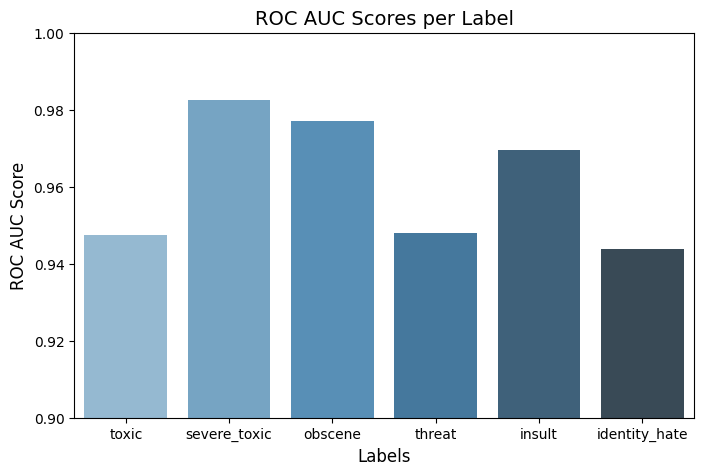

In [ ]:
# AUC-ROC Visualisasi


# Data untuk ROC AUC Score
labels = list(roc_auc_scores.keys())
scores = list(roc_auc_scores.values())

# Bar Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=labels, y=scores, palette="Blues_d")
plt.title("ROC AUC Scores per Label", fontsize=14)
plt.ylabel("ROC AUC Score", fontsize=12)
plt.xlabel("Labels", fontsize=12)
plt.ylim(0.9, 1.0)
plt.show()



# Prediction Function

In [ ]:
# Function to predict toxicity for new texts
def predict_toxicity(text, threshold=0.5):
    # Preprocess and pad the text
    text_seq = tokenizer.texts_to_sequences([text])
    text_pad = pad_sequences(text_seq, maxlen=max_len)

    # Make prediction
    pred = best_model.predict(text_pad)[0]

    # Prepare results
    labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    result = {label: round(score, 4) for label, score in zip(labels, pred)}

    # Determine overall classification
    highest_score_label = labels[np.argmax(pred)]
    highest_score = np.max(pred)

    result["overall"] = "Non-toxic" if highest_score < threshold else highest_score_label

    return result

In [ ]:
text_input = "Fuck you bitch, Everything you say is garbage, and no one can stand you."
print(predict_toxicity(text_input))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
{'toxic': 1.0, 'severe_toxic': 0.4323, 'obscene': 1.0, 'threat': 0.0169, 'insult': 0.992, 'identity_hate': 0.0298, 'overall': 'toxic'}


In [ ]:
text_input = "you pissing me off you suckass stop blabbering can you"
print(predict_toxicity(text_input))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
{'toxic': 0.8512, 'severe_toxic': 0.1395, 'obscene': 0.5146, 'threat': 0.143, 'insult': 0.5903, 'identity_hate': 0.194, 'overall': 'toxic'}


In [ ]:
text_input = "it seems today was pretty good day for me, do you want some gaming session later tonight?"
print(predict_toxicity(text_input))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
{'toxic': 0.0, 'severe_toxic': 0.0, 'obscene': 0.0, 'threat': 0.0, 'insult': 0.0, 'identity_hate': 0.0, 'overall': 'Non-toxic'}


# Visualization

## Distribution Comment Categories

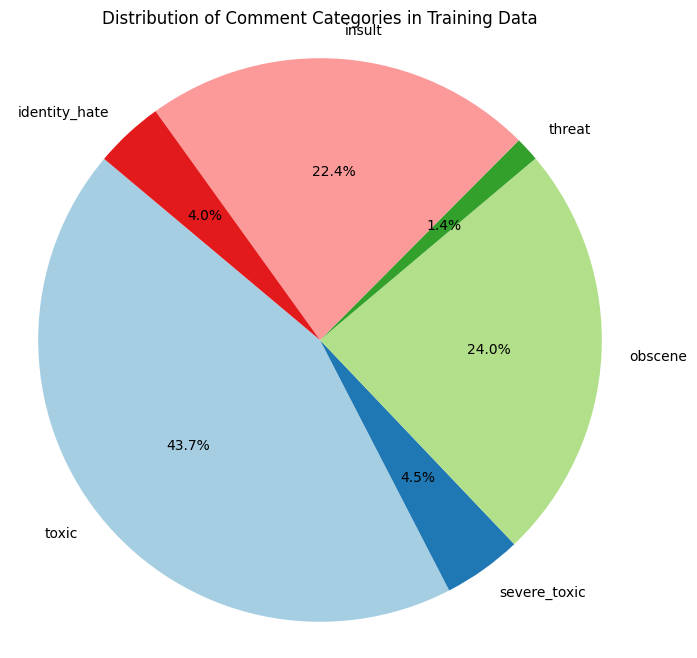

In [ ]:
# Get the sum of each label from the training data
category_counts = train_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title("Distribution of Comment Categories in Training Data")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Display the chart
plt.show()

## Distribution Comment Multilabel

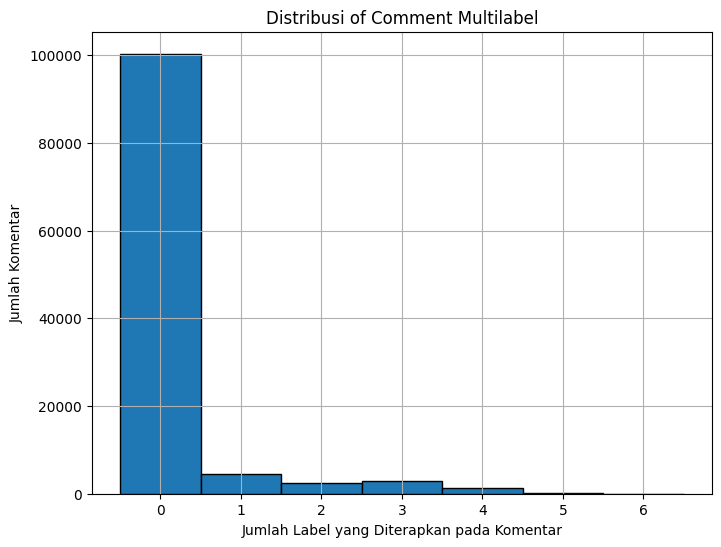

In [ ]:
# Menghitung jumlah label yang relevan untuk setiap komentar (jumlah nilai 1 per baris)
multilabel_counts = train_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1)

# Membuat histogram untuk mendeteksi multilabel
plt.figure(figsize=(8, 6))
plt.hist(multilabel_counts, bins=range(0, 8), edgecolor='black', align='left')
plt.xlabel('Jumlah Label yang Diterapkan pada Komentar')
plt.ylabel('Jumlah Komentar')
plt.title('Distribusi of Comment Multilabel')
plt.xticks(range(0, 7))  # Menambahkan label x-axis untuk 0 hingga 6 label
plt.grid(True)
plt.show()

## Distribution Comment Lengths

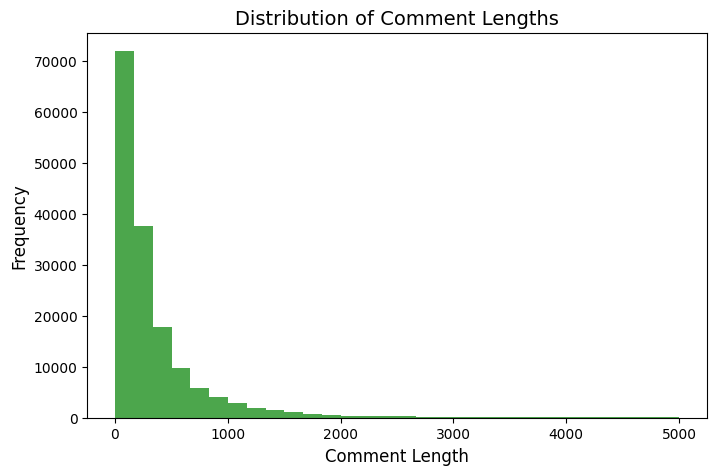

In [ ]:
# Distribusi Panjang Teks Visualisasi

# Calculate text lengths
text_lengths = data['comment_text'].apply(len)

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(text_lengths, bins=30, color="green", alpha=0.7)
plt.title("Distribution of Comment Lengths", fontsize=14)
plt.xlabel("Comment Length", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()


## Wordcloud Categories

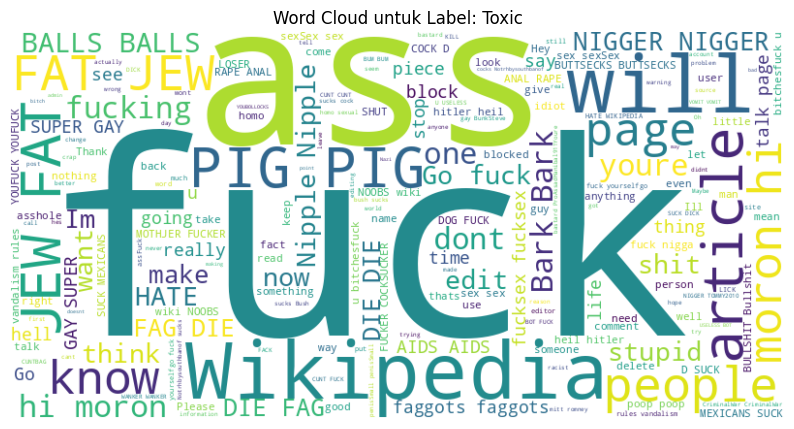

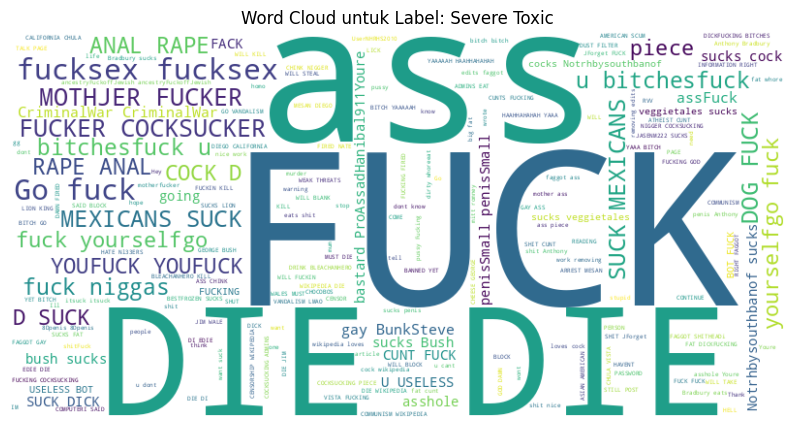

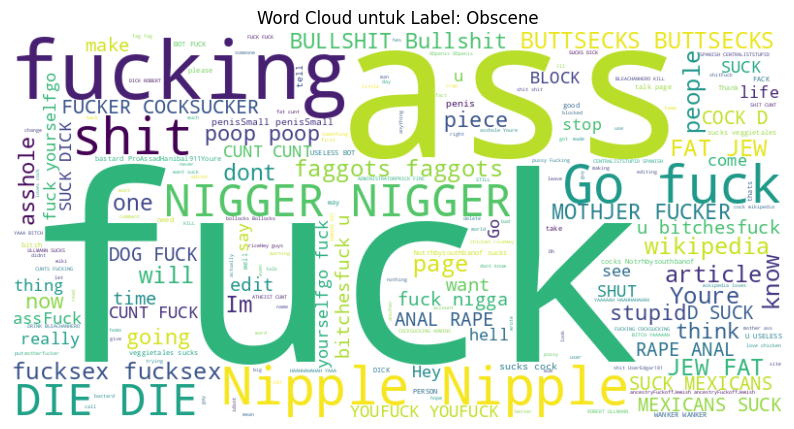

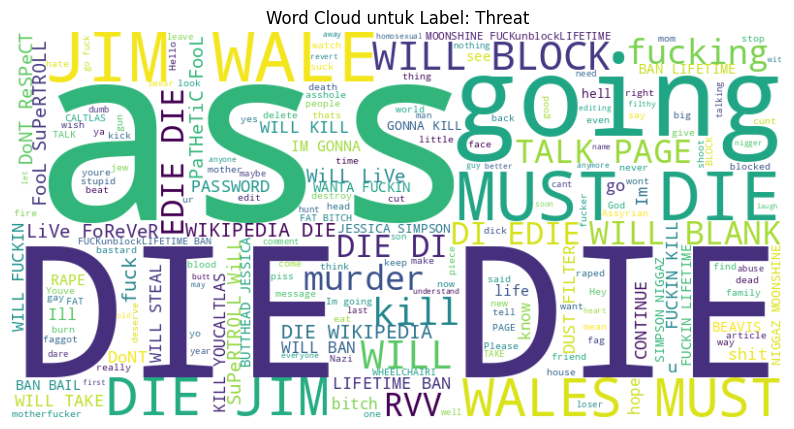

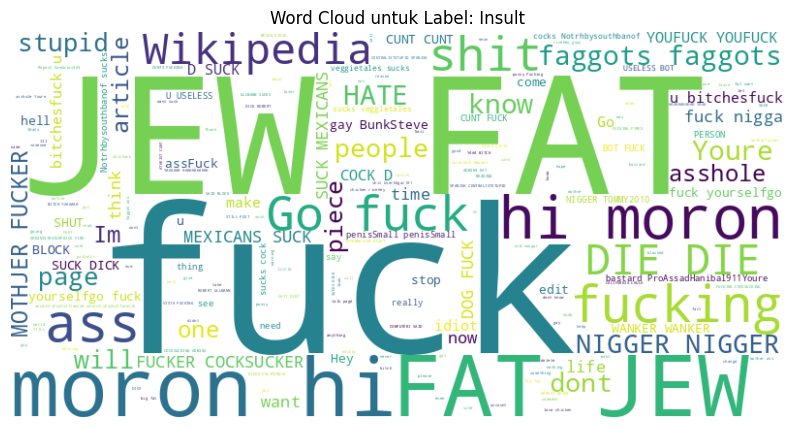

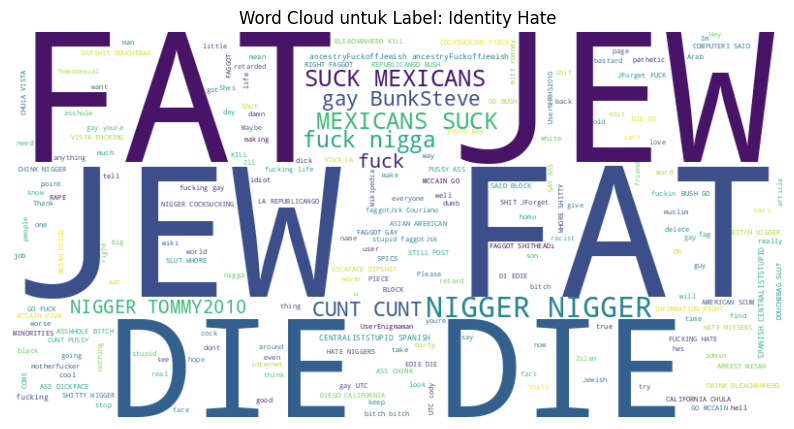

In [ ]:
from wordcloud import WordCloud

# Fungsi untuk menghasilkan word cloud berdasarkan label tertentu
def generate_wordcloud(data, label, label_name):
    # Ambil semua komentar yang memiliki label 1
    text = data[data[label] == 1]['comment_text'].str.cat(sep=' ')

    # Buat word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Plotting word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud untuk Label: {label_name}')

    # Simpan gambar ke file terpisah
    plt.savefig(f'wordcloud_{label_name}.png', bbox_inches='tight')
    plt.show()

# Membuat word cloud untuk setiap label
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
label_names = ['Toxic', 'Severe Toxic', 'Obscene', 'Threat', 'Insult', 'Identity Hate']

for label, label_name in zip(labels, label_names):
    generate_wordcloud(train_data, label, label_name)

## Distribution Heatmap Corelation Label

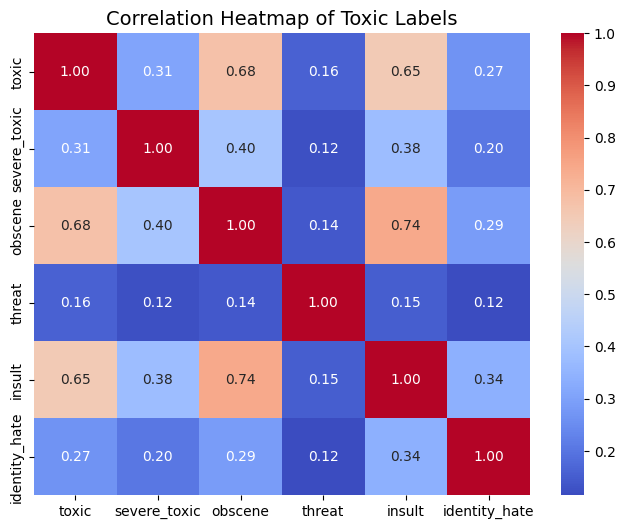

In [ ]:
# Heatmap Korelasi Label
# Compute correlation matrix
correlation_matrix = data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Toxic Labels", fontsize=14)
plt.show()


## Distribution Validation Accuracy & Loss

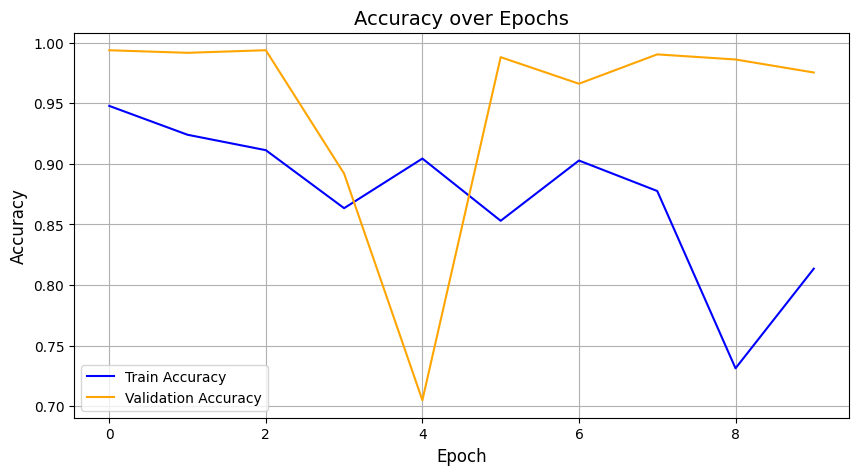

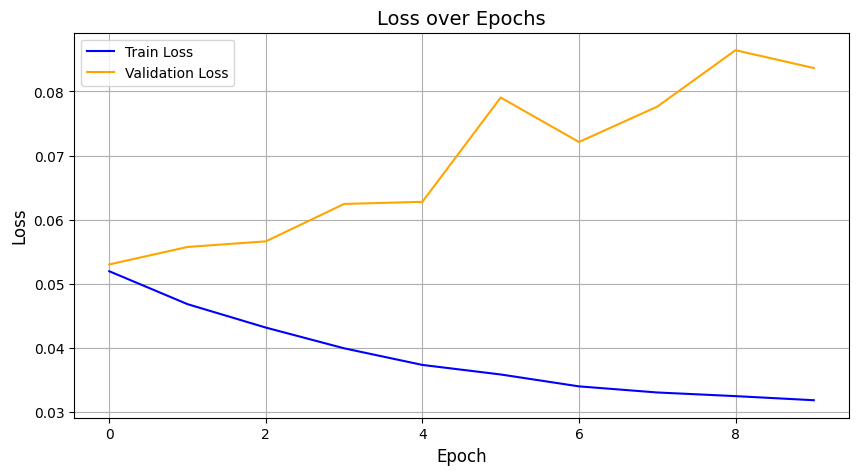

In [ ]:
# Performa Training Visualisasi
# Plot training and validation accuracy
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title("Accuracy over Epochs", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title("Loss over Epochs", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()



## Confusion Matrix

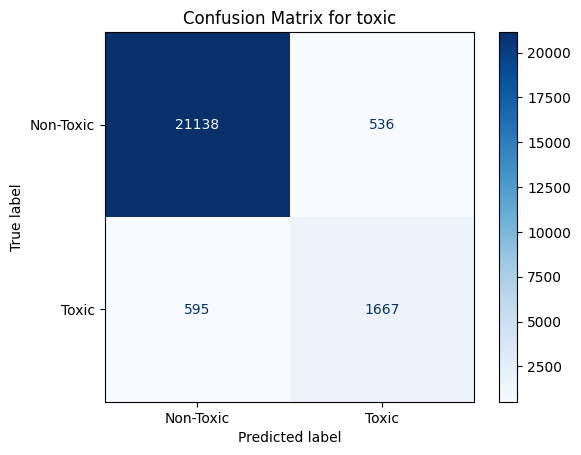

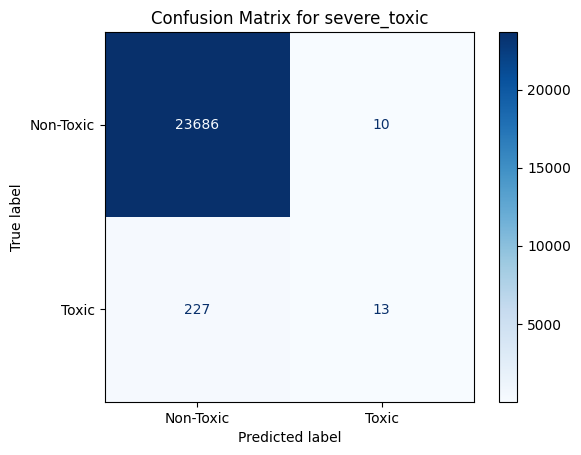

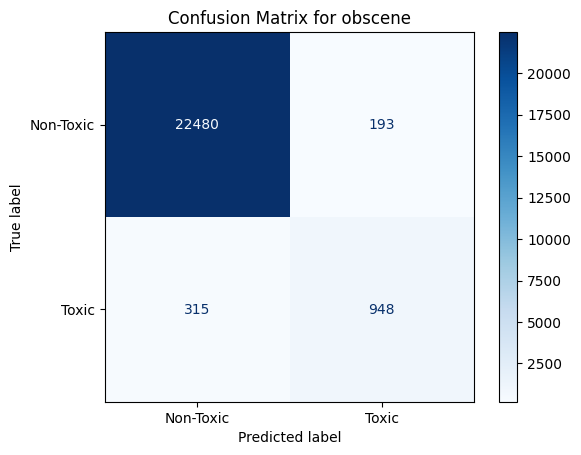

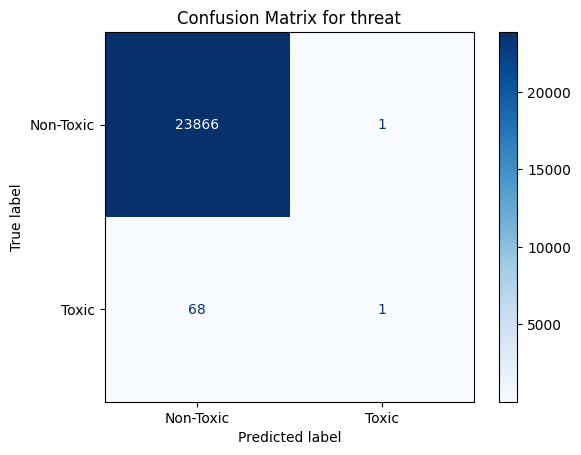

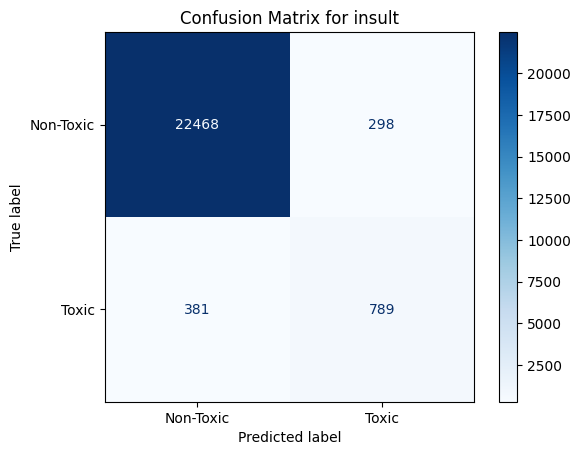

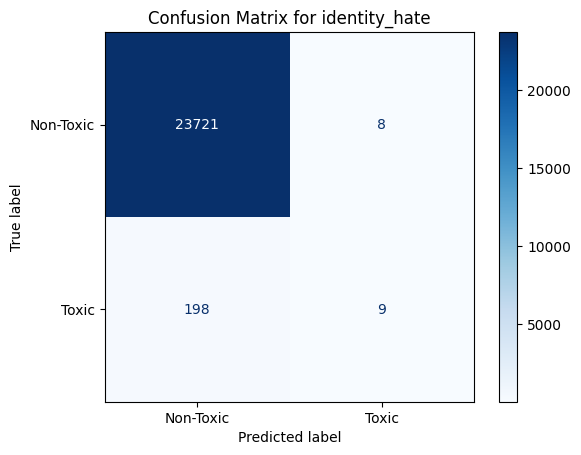

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert probabilities to binary predictions
threshold = 0.5
y_val_pred_binary = (y_val_pred >= threshold).astype(int)

# Confusion matrix for each label
for i, label in enumerate(labels):
    cm = confusion_matrix(y_val[:, i], y_val_pred_binary[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Toxic", "Toxic"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix for {label}")
    plt.show()
